## Постановка задачи
Необходимо спрогнозировать, посетит ли клиент забронированное занятие, на основе истории посещаемости тренировок клиента. 
Цель - выявить закономерность и факторы,влияющие на неявку. 

### Подключение модулей

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns

### Загрузка данных

In [3]:
df = pd.read_csv("fitness_class_2212.csv")

In [4]:
df.head(10)

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
5,6,7,93.33,2,Mon,AM,Cycling,0
6,7,11,88.59,6,Wednesday,PM,HIIT,0
7,8,9,89.52,10,Fri,AM,HIIT,0
8,9,23,71.12,10,Fri.,AM,HIIT,1
9,10,7,81.25,10,Fri,AM,HIIT,0


### Описание данных

Признаки:
- booking_id - Уникальный идентификатор бронирования(ID бронирования)
- months_as_member - Сколько месяцев человек является клиентом фитнес-клуба
- weight - Вес клиента
- days_before - За сколько дней до занятия была сделана бронь
- day_of_week - День тренировки
- time - Запланированное время тренировки(день/вечер)
- category - Тип тренировки

Целевой (искомый) признак:

- attended - Факт посещения занятия

In [5]:
df.shape

(1500, 8)

Вывели общее количество строк и столбцов

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


Данные содержат 1500 записей и 8 столбцов с различными характеристиками клиентов.
Есть 20 пропусков в столбце "weight"

In [7]:
df.describe()

,booking_id,months_as_member,weight,attended
count,1500.000000,1500.000000,1480.000000,1500.000000
mean,750.500000,15.628667,82.610378,0.302667
std,433.157015,12.926543,12.765859,0.459565
min,1.000000,1.000000,55.410000,0.000000
25%,375.750000,8.000000,73.490000,0.000000
50%,750.500000,12.000000,80.760000,0.000000
75%,1125.250000,19.000000,89.520000,1.000000
max,1500.000000,148.000000,170.520000,1.000000


Есть аномалии в весе и в продолжительности посещения клиенты/клиентов клуба.

In [8]:
df[df['months_as_member'] > 60]['months_as_member'].value_counts()

months_as_member
73     2
66     2
65     2
76     1
62     1
105    1
90     1
107    1
89     1
61     1
97     1
93     1
148    1
111    1
69     1
Name: count, dtype: int64

Сначала проанализируем клиентов, которые посещают клуб более 5 лет

In [9]:
df = df[df['months_as_member'] <= 60].copy()

Удалили аномалии в посещаемости. Остались только клиенты,которые посещают клуб не более 5 лет.

In [10]:
df[df['weight'] > 120]['weight'].value_counts()

weight
148.02    1
124.30    1
135.18    1
122.36    1
120.58    1
170.52    1
121.38    1
123.90    1
120.81    1
127.59    1
136.02    1
133.36    1
129.28    1
Name: count, dtype: int64

Также проанализируем клиентов с аномальным весом

In [11]:
df = df[df['weight'] <= 140].copy()

Удалили аномалии в весе клиентов.Остались клиенты с весом меньше 140 кг

In [12]:
df.isna().sum()

booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

Пропуски не найдены.

In [13]:
(df == "-").sum()

booking_id           0
months_as_member     0
weight               0
days_before          0
day_of_week          0
time                 0
category            13
attended             0
dtype: int64

Есть 13 пропусков в столбце категории.

In [14]:
df = df[df['category'] != "-"].copy()

In [15]:
(df == "-").sum()

booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

Удалили данные пропуски.

In [16]:
print(df.duplicated().sum())

0


Дубликатов не найдено.

### Целевая переменная — attended

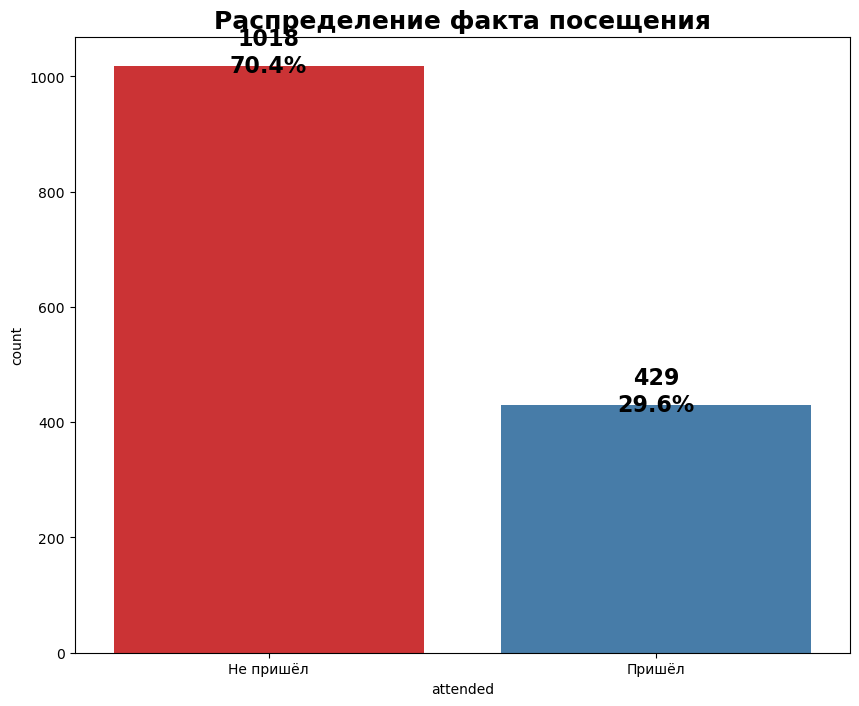

In [27]:
rate = df['attended'].mean() * 100

plt.figure(figsize=(10,8))
ax = sns.countplot(data=df, x='attended', hue='attended', palette='Set1', legend=False)
plt.title('Распределение факта посещения', fontsize=18, fontweight='bold')
plt.xticks([0,1], ['Не пришёл', 'Пришёл'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}\n{100*height/len(df):.1f}%', 
                (p.get_x() + p.get_width()/2., height), 
                ha='center', va='center', fontsize=16, fontweight='bold', xytext=(0, 10), textcoords='offset points')
plt.show()

### Числовые признаки

In [28]:
num_cols = ['months_as_member', 'weight', 'days_before']
df[num_cols].describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
months_as_member,1447.000000,14.829993,10.249858,1.000000,8.000000,12.000000,19.000000,60.000000
weight,1447.000000,82.711707,12.396203,55.410000,73.625000,80.930000,89.585000,136.020000
days_before,1422.000000,8.362869,4.081227,1.000000,4.000000,9.000000,12.000000,29.000000


### Категориальные признаки

In [29]:
cat_cols = ['day_of_week', 'time', 'category']

for col in cat_cols:
    print(f"\nРаспределение по {col}:")
    display(df[col].value_counts().to_frame())


Распределение по day_of_week:


,count
day_of_week,
Fri,272
Thu,229
Mon,208
Sun,207
Sat,193
Tue,188
Wed,79
Wednesday,35
Fri.,26



Распределение по time:


,count
time,
AM,1103
PM,344



Распределение по category:


,count
category,
HIIT,646
Cycling,369
Strength,227
Yoga,133
Aqua,72


# Многомерный анализ

### Важнейший фактор — стаж членства

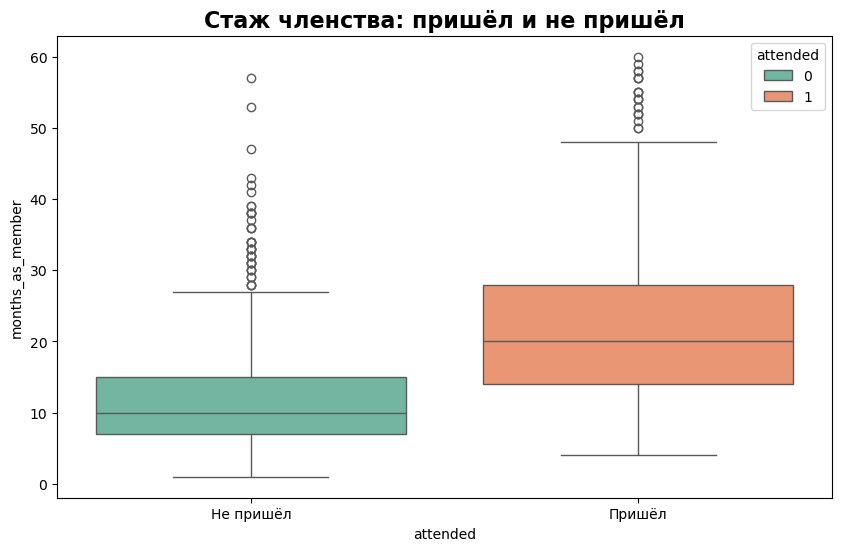

In [30]:
came = df[df['attended']==1]['months_as_member'].mean()
not_came = df[df['attended']==0]['months_as_member'].mean()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='attended', hue='attended', y='months_as_member', palette='Set2')
plt.title('Стаж членства: пришёл и не пришёл', fontsize=16, fontweight='bold')
plt.xticks([0,1], ['Не пришёл', 'Пришёл'])
plt.show()

### Посещаемость по типу занятия

In [31]:
cat_att = df.groupby('category')['attended'].agg(['count', 'mean']).round(3)
cat_att['mean'] = (cat_att['mean'] * 100).round(1)
cat_att = cat_att.sort_values('mean', ascending=False)
cat_att.columns = ['Бронирований', 'Посещаемость (%)']
cat_att.style.background_gradient(cmap='RdYlGn', subset='Посещаемость (%)')

,Бронирований,Посещаемость (%)
category,,
Aqua,72,31.900000
HIIT,646,31.000000
Yoga,133,30.800000
Cycling,369,29.000000
Strength,227,25.600000


### Посещаемость по дням недели и времени

In [32]:
day_time = df.groupby(['day_of_week', 'time'])['attended'].mean().unstack() * 100
day_time = day_time.round(1)[['AM', 'PM']]
day_time.style.background_gradient(cmap='RdYlGn', axis=None)

time,AM,PM
day_of_week,,
Fri,29.200000,37.500000
Fri.,50.000000,0.000000
Mon,27.600000,29.600000
Monday,30.000000,nan
Sat,29.600000,29.400000
Sun,34.400000,26.000000
Thu,32.700000,27.800000
Tue,33.600000,25.600000
Wed,16.100000,12.500000


### Кросс-таблица: категория на день недели

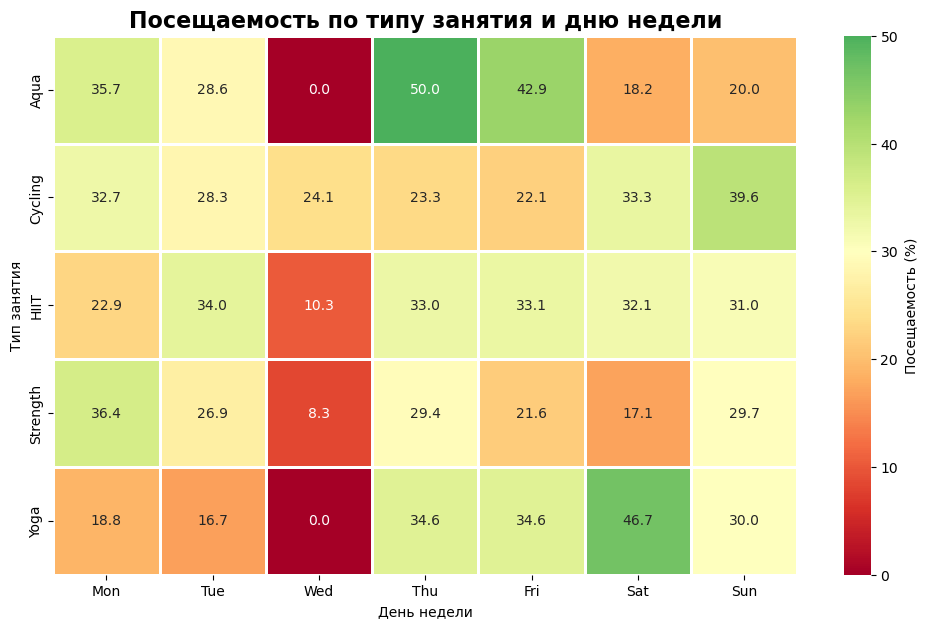

In [33]:
cross = df.pivot_table(values='attended', index='category', columns='day_of_week', aggfunc='mean') * 100
cross = cross.round(1)[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]

plt.figure(figsize=(12,7))
sns.heatmap(cross, annot=True, cmap='RdYlGn', center=30, fmt='.1f', linewidths=1, cbar_kws={'label': 'Посещаемость (%)'})
plt.title('Посещаемость по типу занятия и дню недели', fontsize=16, fontweight='bold')
plt.xlabel('День недели')
plt.ylabel('Тип занятия')
plt.show()

### Влияние срока бронирования

In [34]:
df['days_before'] = pd.to_numeric(df['days_before'], errors='coerce')
df['days_group'] = pd.cut(df['days_before'], bins=[-0.001, 3, 7, 14, 30], labels=['0-3 дня', '4-7 дней', '8-14 дней', '15+ дней'])
days_att = df.groupby('days_group', observed=True)['attended'].mean() * 100
days_att.round(1).to_frame('Посещаемость (%)').style.background_gradient(cmap='RdYlGn')

,Посещаемость (%)
days_group,
0-3 дня,27.100000
4-7 дней,28.000000
8-14 дней,30.100000
15+ дней,41.900000


# Ключевые выводы EDA

1. **Посещаемость всего 30.3%** — критически низкая
2. **Главный фактор — стаж членства** (в 2.2 раза выше у пришедших)
3. **Лучшие занятия:** Aqua, HIIT, Yoga
4. **Худший день — среда** (особенно вечером)
5. **Утро (AM) в 1.5 раза лучше вечера**
6. **Чем раньше бронь — тем ниже вероятность прийти**
7. **Новички (до 6 месяцев) — главная группа риска**